# Optimizing Model - Parameter Optimization for LightGBM

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from scipy import stats
from sklearn.model_selection import train_test_split

In [2]:
data_flight_info = pd.read_csv('/Users/craiglynch/Desktop/Lighthouse_Labs/Mid-term_Project/mid-term-project-I-master/Regression_no_outliers_cleaned_data_01.csv', sep = ',')

In [3]:
data_flight_info.shape

(578888, 24)

In [4]:
data_weather = pd.read_csv('/Users/craiglynch/Desktop/Lighthouse_Labs/Mid-term_Project/mid-term-project-I-master/weather.csv', sep = ',')

In [5]:
data_weather.shape

(14099, 39)

In [6]:
df_flight_info = data_flight_info.copy()
df_weather = data_weather.copy()

In [7]:
#Only want top 19 busiest airports
airports = ['ORD','ATL','DFW','DEN','LAX','CLT','SEA','SFO','EWR','LGA','PHX','IAH','LAS','BOS','MCO','DTW','PHIL','DCA','MSP']
df_flight_info = df_flight_info[df_flight_info['origin'].isin(airports)]
df_flight_info.origin.value_counts()

ATL    59064
ORD    58664
DFW    43987
DEN    41728
CLT    37849
LAX    37708
SEA    29061
PHX    27108
SFO    27099
IAH    26839
DTW    26369
LGA    25168
LAS    25150
MSP    24522
EWR    23629
BOS    22588
DCA    21241
MCO    21114
Name: origin, dtype: int64

In [8]:
df_weather['value'] = df_weather['value'].str.lower()
# create a list of our conditions
conditions = [
    (df_weather['value'].str.contains('sunny')),
    (df_weather['value'].str.contains('cloud')),
    (df_weather['value'].str.contains('mist')),
    (df_weather['value'].str.contains('fog')),
    (df_weather['value'].str.contains('overcast')),
    (df_weather['value'].str.contains('rain')),
    (df_weather['value'].str.contains('drizzle')),
    (df_weather['value'].str.contains('thunder')),
    (df_weather['value'].str.contains('snow')),
    (df_weather['value'].str.contains('sleet')),
    (df_weather['value'].str.contains('blizzard')),
    ]

# create a list of the values we want to assign for each condition
values = ['sunny', 'cloudy', 'cloudy','cloudy','cloudy','rain','rain','rain','snow','snow','snow']

# create a new column and use np.select to assign values to it using our lists as arguments
df_weather['weather_type'] = np.select(conditions, values)
df_weather['weather_type'].value_counts()

sunny     5503
cloudy    4324
rain      2860
snow      1412
Name: weather_type, dtype: int64

In [9]:
df_weather['value'].value_counts().sum()

14099

In [10]:
# Creating year, month, date columns
df_weather['year'] = pd.DatetimeIndex(df_weather['date']).year
df_weather['month'] = pd.DatetimeIndex(df_weather['date']).month
df_weather['day'] = pd.DatetimeIndex(df_weather['date']).day
df_weather['weekday'] = ((pd.DatetimeIndex(df_weather['date']).dayofweek))

#### Merging weather data with flight data

In [11]:
df_weather.rename(columns={'date': 'fl_date', 'airport_code': 'origin'}, inplace=True)

In [12]:
df_flight_info = pd.merge(df_flight_info, df_weather[['fl_date','origin','weather_type']],  how='left', left_on=['fl_date','origin'], right_on = ['fl_date','origin'])


In [13]:
df_flight_info.shape

(632865, 25)

In [14]:
# Dropping the small number of null weather types
df_flight_info = df_flight_info.dropna()

In [15]:
# Finding average route times
df_flight_info['flight_number'] = df_flight_info['op_unique_carrier'] + df_flight_info['op_carrier_fl_num'].astype(str)
route_time_grouped = df_flight_info.groupby(by='flight_number').mean()
route_time_grouped.reset_index(inplace=True)
route_time_grouped['average_route_time'] = route_time_grouped['actual_elapsed_time']
route_time_grouped = route_time_grouped[['flight_number','average_route_time']]

In [16]:
# Getting Average Carrier Delay - Grouped by Carrier
carrier_grouped = df_flight_info.groupby(by='op_unique_carrier').mean()
carrier_grouped.reset_index(inplace=True)
carrier_grouped['total_carrier_delay'] = carrier_grouped['carrier_delay'] + carrier_grouped['late_aircraft_delay']
carrier_grouped = carrier_grouped[['op_unique_carrier', 'total_carrier_delay']]

In [17]:
# Getting Average Weather Delay
weather_grouped1 = df_flight_info.groupby(by=['origin','month']).mean()
weather_grouped1.reset_index(inplace=True)
weather_grouped1['total_weather_delay'] = weather_grouped1['weather_delay']
weather_grouped1 = weather_grouped1[['origin','total_weather_delay']]

In [18]:
# Getting Average NAS Delay - Grouped by Flight Number
nas_grouped = df_flight_info.groupby(by='flight_number').mean()
nas_grouped.reset_index(inplace=True)
nas_grouped['total_nas_delay'] = nas_grouped['nas_delay']
nas_grouped = nas_grouped[['flight_number', 'total_nas_delay']]

# Getting Average Security Delay
security_grouped = df_flight_info.groupby(by='origin').mean()
security_grouped.reset_index(inplace=True)
security_grouped['total_security_delay'] = security_grouped['security_delay']
security_grouped = security_grouped[['origin','total_security_delay']]

# Getting Average Departure Delays by Route
dep_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
dep_delay_grouped.reset_index(inplace=True)
dep_delay_grouped['total_dep_delay'] = dep_delay_grouped['dep_delay']
dep_delay_grouped = dep_delay_grouped[['flight_number','total_dep_delay']]

# Getting Average Arrival Delays by Route
arr_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
arr_delay_grouped.reset_index(inplace=True)
arr_delay_grouped['total_arr_delay'] = arr_delay_grouped['arr_delay']
arr_delay_grouped = arr_delay_grouped[['flight_number','total_arr_delay']]

#Merge averages dataframes with original 
df_flight_info = df_flight_info.merge(security_grouped, on = 'origin', how = 'outer')
df_flight_info = df_flight_info.merge(nas_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(route_time_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(dep_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(arr_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(weather_grouped1, on = 'origin', how = 'outer')
df_flight_info = df_flight_info.merge(carrier_grouped, on = 'op_unique_carrier', how = 'outer')

## Model Training

In [19]:
#df_flight_info.isnull().sum()

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, r2_score, f1_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

In [21]:
# encoding df_flight_info 
df_flight_info["weather_type"] = df_flight_info["weather_type"].astype('category').cat.codes
df_flight_info["flight_number"] = df_flight_info["flight_number"].astype('category').cat.codes

In [22]:
df_flight_info.dtypes

fl_date                  object
mkt_unique_carrier       object
op_unique_carrier        object
op_carrier_fl_num         int64
origin                   object
crs_dep_time              int64
dep_time                float64
dep_delay               float64
dest                     object
arr_time                float64
arr_delay               float64
crs_arr_time              int64
crs_elapsed_time        float64
actual_elapsed_time     float64
distance                float64
carrier_delay           float64
weather_delay           float64
nas_delay               float64
security_delay          float64
late_aircraft_delay     float64
year                      int64
month                     int64
day                       int64
weekday                 float64
weather_type               int8
flight_number             int16
total_security_delay    float64
total_nas_delay         float64
average_route_time      float64
total_dep_delay         float64
total_arr_delay         float64
total_we

### Adding Total Weather Delay

In [23]:
df_flight_info = shuffle(df_flight_info)
X = df_flight_info[['crs_dep_time','flight_number','crs_elapsed_time','average_route_time','crs_arr_time','distance','year','month','day','weekday','total_carrier_delay', 'total_security_delay','total_nas_delay','total_dep_delay','total_arr_delay','weather_type','total_weather_delay']]
y = df_flight_info['arr_delay']

In [24]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

##### LightGBM

In [76]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.8277896457253541
params['boosting_type'] = 'gbdt'
#params['boosting_type'] = 'dart'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['sub_feature'] = 0.5
params['num_leaves'] = 62
params['min_data'] = 55
params['max_depth'] = 27
y_train=y_train.ravel()
reg= lgb.train(params, d_train, 100)
results=reg.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, results)))
print('Model R2 Score is: ',r2_score(y_test,results))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.262296
Model RMSE is:  37.13007085396963
Model R2 Score is:  0.2468144358480726


##### XGBoost

In [25]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_test,y_test)

y_pred_xgb = xg_reg.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_xgb))

Model RMSE is:  41.637426035474334
Model R2 Score is:  0.053094363570214465


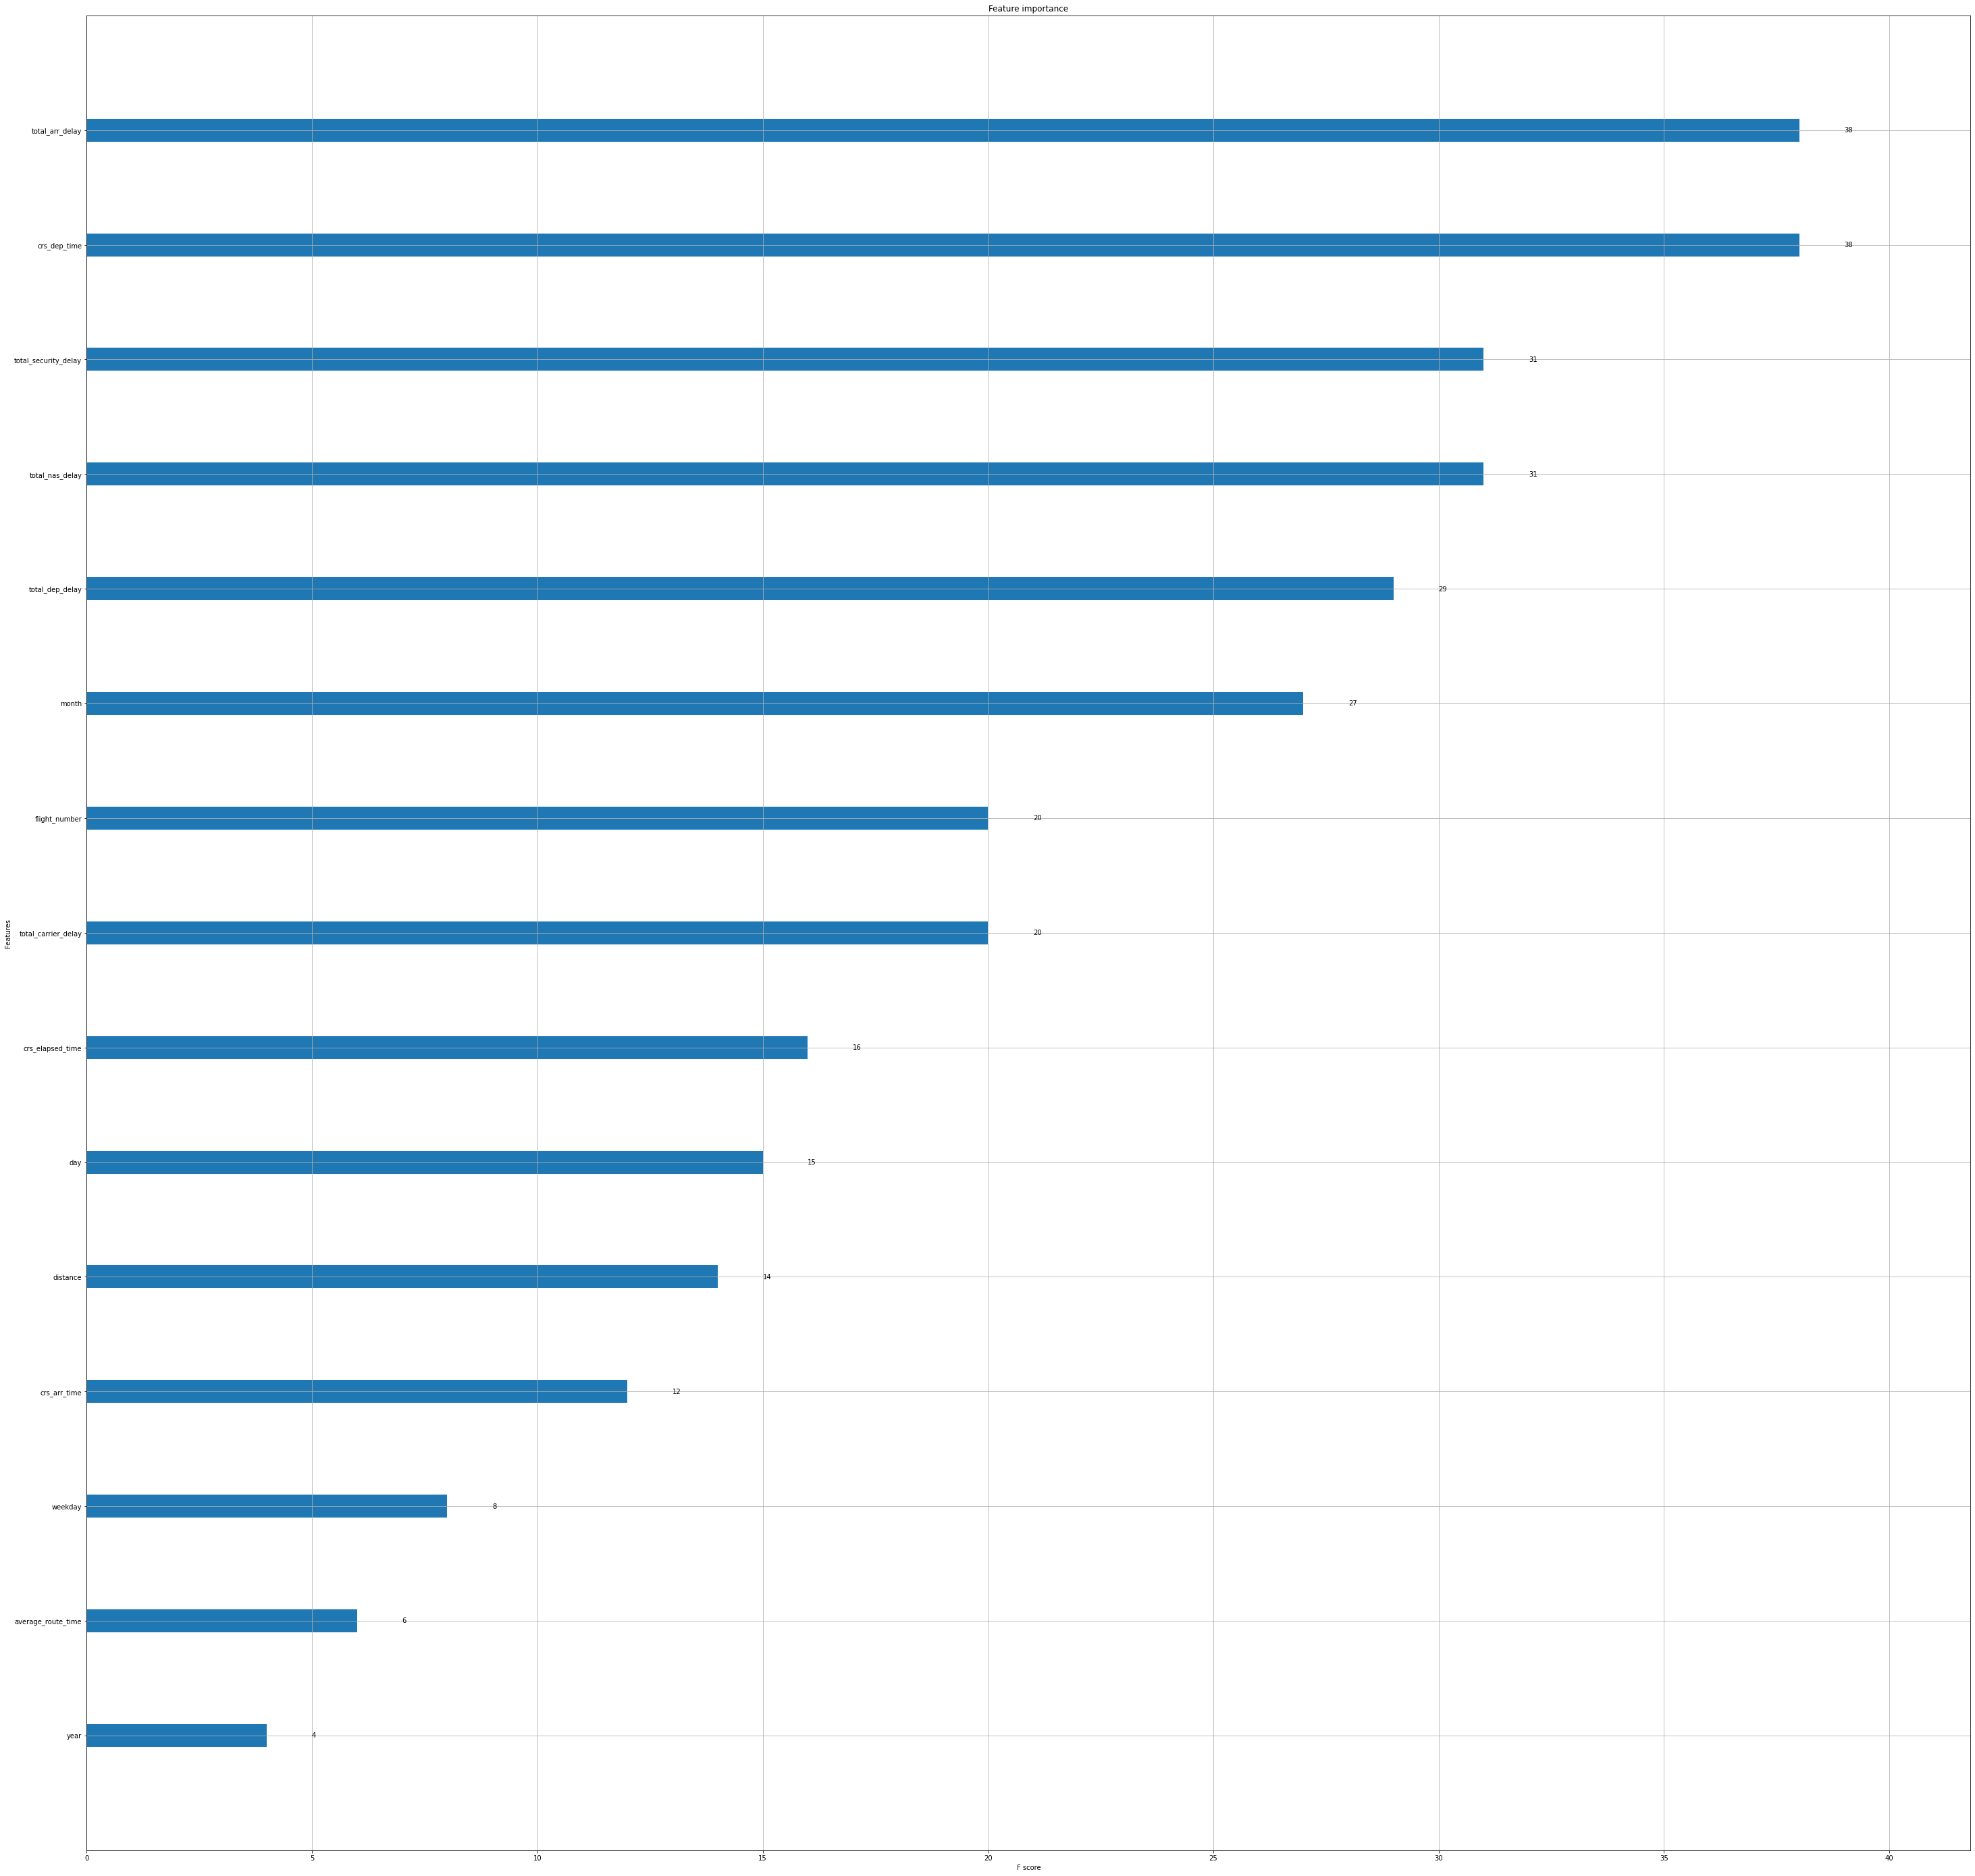

In [27]:
#Examine the importance of each feature column in the original data set with the model
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

##### Linear Regression

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X=scaler.fit_transform(X)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# creating linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_lr = lr.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_lr)))
print('Model R2 Score is: ',r2_score(y_test,y_lr))

Model RMSE is:  40.87799890891109
Model R2 Score is:  0.07935852635745144


##### Ridge/Lasso Regression

In [32]:
ridgereg = Ridge(alpha=0.001,normalize=True)
ridge = ridgereg.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_ridge))

lassoreg = Lasso(alpha=0.001,normalize=True)
lasso = lassoreg.fit(X_train,y_train)
y_pred_lasso = lasso.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_lasso))

Model RMSE is:  40.87799937381859
Model R2 Score is:  0.07935850541644951
Model RMSE is:  41.006790452236814
Model R2 Score is:  0.07354818211543523


##### Random Forest

In [ ]:
#Create a Gaussian Regressor
clf=RandomForestRegressor(n_estimators=100)

In [ ]:
#Train the model using the training sets 
clf.fit(X_train,y_train)

In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print('Model R2 Score is: ',r2_score(y_test,y_pred))